<a href="https://colab.research.google.com/github/kamileo96/GNN-Tracking/blob/main/GNN_muonE_2D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial: GNNs for Particle Tracking

HEP.TrkX group

Steve Farrell, Daniel Murname

*Feb 2020*

Adapted for MuonE tracking by Marcin Wolter

*July 2020*

In [2]:
!pip uninstall torchvision torchtext torchaudio --yes
!pip install torch==1.11.0+cu113  -f https://download.pytorch.org/whl/torch_stable.html

Found existing installation: torchvision 0.14.1+cu116
Uninstalling torchvision-0.14.1+cu116:
  Successfully uninstalled torchvision-0.14.1+cu116
Found existing installation: torchtext 0.14.1
Uninstalling torchtext-0.14.1:
  Successfully uninstalled torchtext-0.14.1
Found existing installation: torchaudio 0.13.1+cu116
Uninstalling torchaudio-0.13.1+cu116:
  Successfully uninstalled torchaudio-0.13.1+cu116
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 GB 1.1 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 1.13.1+cu116
    Uninstalling torch-1.13.1+cu116:
      Successfully uninstalled torch-1.13.1+cu116
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fa

In [3]:
# System imports
import os
import sys
from pprint import pprint as pp
from time import time as tt

# External imports
import matplotlib.pyplot as plt
import matplotlib.colors
import numpy as np
import pandas as pd
import seaborn as sns
import torch

In [4]:
print("PyTorch version:",print(torch.__version__),", CUDA version:", torch.version.cuda)

1.11.0+cu113
PyTorch version: None , CUDA version: 11.3


In [5]:
#!pip install torch-scatter==latest+cu101 torch-sparse==latest+cu101 -f https://s3.eu-central-1.amazonaws.com/pytorch-geometric.com/whl/torch-1.5.0.html
"""
!pip install torch-geometric
!pip install torch-sparse
!pip install torch-scatter"""
# MW corrected

!pip install torch-geometric \
  torch-sparse==0.6.13 \
  torch-scatter==2.0.9 \
  -f https://pytorch-geometric.com/whl/torch-1.11.0+cu113.html


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://pytorch-geometric.com/whl/torch-1.11.0+cu113.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 565.0/565.0 KB 9.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.2/280.2 KB 21.9 MB/s eta 0:00:00
  Created wheel for torch-geometric: filename=torch_geometric-2.2.0-py3-none-any.whl size=773302 sha256=e4e0dbfc215fb63768af890c2374f9c7360dcc2bf5b32983db22da484708139c
  Stored in directory: /root/.cache/pip/wheels/59/a3/20/198928106d3169865ae73afcbd3d3d1796cf6b429b55c65378
Successfully built torch-geometric
  Attempting uninstall: psutil
    Found existing installation: psutil 5.4.8
    Uninstalling psutil-5.4.8:
      Successfully uninstalled psutil-5.4.8


In [6]:
from torch_geometric.data import Data
from torch_geometric.data import DataLoader
import torch.nn as nn
from torch_scatter import scatter_add
import torch.nn.functional as F

import ipywidgets as widgets
from ipywidgets import interact, interact_manual
from IPython.display import clear_output
from IPython.display import HTML, display

%matplotlib inline

# Get rid of RuntimeWarnings, gross
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

## A Simple GNN

### Message Passing GNN

We can write out the full GNN as a class `MPNN_Network`. One can see its behaviour as:
1. Encode (x,y) features as hidden features with an N-layer MLP called `node_encoder`
2. Concatenate these along each edge, and feed the concatenated features into another MLP called `edge_network`
3. Sum the output of `edge_classifier` at each node (that is, each node receives the sum of the "messages" of all connecting edges). This sum is fed into `node_network`
4. Add the hidden features to the previous iteration (this helps to preserve information between messages)
5. Repeat (2) --> (4) n_graph_iters times
6. After the message passing loop, pass the features of each edge through an output classifier network called `edge_classifier`

In [7]:
def make_mlp(input_size, sizes,
             hidden_activation='ReLU',
             output_activation='ReLU',
             layer_norm=False):
    """Construct an MLP with specified fully-connected layers."""

    hidden_activation = getattr(nn, hidden_activation)
    if output_activation is not None:
        output_activation = getattr(nn, output_activation)
    layers = []
    n_layers = len(sizes)
    sizes = [input_size] + sizes
    # Hidden layers

    for i in range(n_layers-1):
        layers.append(nn.Linear(sizes[i], sizes[i+1]))
        if layer_norm:
            layers.append(nn.LayerNorm(sizes[i+1]))
        layers.append(hidden_activation())

    # Final layer
    layers.append(nn.Linear(sizes[-2], sizes[-1]))
    if output_activation is not None:
        if layer_norm:
            layers.append(nn.LayerNorm(sizes[-1]))
        layers.append(output_activation())
    return nn.Sequential(*layers)

class MPNN_Network(nn.Module):
    """
    A message-passing graph network which takes a graph with:
    - bi-directional edges
    - node features, no edge features

    and applies the following modules:
    - a graph encoder (no message passing)
    - recurrent edge and node networks
    - an edge classifier
    """

    def __init__(self, input_dim, hidden_node_dim, hidden_edge_dim, in_layers, node_layers, edge_layers,
                 n_graph_iters=1, layer_norm=True,normalize_factor= 1):
        super(MPNN_Network, self).__init__()
        self.n_graph_iters = n_graph_iters

        # The node encoder transforms input node features to the hidden space
        self.node_encoder = make_mlp(input_dim, [hidden_node_dim]*in_layers)

        # The edge network computes new edge features from connected nodes
        self.edge_network = make_mlp(2*hidden_node_dim,
                                     [hidden_edge_dim]*edge_layers,
                                     layer_norm=layer_norm)

        # The node network computes new node features
        self.node_network = make_mlp(hidden_node_dim + hidden_edge_dim,
                                     [hidden_node_dim]*node_layers,
                                     layer_norm=layer_norm)

        # The edge classifier computes final edge scores
        self.edge_classifier = make_mlp(2*hidden_node_dim,
                                        [hidden_edge_dim, 1],
                                        output_activation=None)
        self.normalize_factor=normalize_factor
    def forward(self, data):
        # Make every edge bi-directional
        send_idx = torch.cat([data.edge_index[0], data.edge_index[1]], dim=0)
        recv_idx = torch.cat([data.edge_index[1], data.edge_index[0]], dim=0)
        
        # Encode the graph features into the hidden space
        #print( torch.mean (data.x[:,0]) )
        #print( torch.mean (data.x[:,1]) )
        if self.normalize_factor!=1:
          temp = data.x.clone().detach()
          temp[:,1] *= self.normalize_factor
          x = self.node_encoder(temp)
        else:
          x = self.node_encoder(data.x.clone().detach())
        # Loop over graph iterations
        for i in range(self.n_graph_iters):

            # Previous hidden state
            x0 = x

            # Compute new edge features
            edge_inputs = torch.cat([x[send_idx], x[recv_idx]], dim=1)
            e = self.edge_network(edge_inputs)

            # Sum edge features coming into each node
            aggr_messages = scatter_add(e, recv_idx, dim=0, dim_size=x.shape[0])

            # Compute new node features
            node_inputs = torch.cat([x, aggr_messages], dim=1)
            x = self.node_network(node_inputs)

            # Residual connection
            x = x + x0

        # Compute final edge scores; use original edge directions only
        start_idx, end_idx = data.edge_index
        clf_inputs = torch.cat([x[start_idx], x[end_idx]], dim=1)
        return self.edge_classifier(clf_inputs).squeeze(-1)

### Training

In [8]:
def train(model, train_loader, optimizer):
    correct = 0
    total = 0
    total_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        data = batch.to(device)
        pred = model(data)
        loss = F.binary_cross_entropy_with_logits(pred.float(), data.y.float(), pos_weight=torch.tensor(weight))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        correct += ((pred > 0.5) == (data.y > 0.5)).sum().item()
        total += len(pred)
    acc = correct/total
    return acc, total_loss

def evaluate(model, test_loader):
    correct = 0
    total = 0
    total_loss = 0
    for batch in test_loader:
        data = batch.to(device)
        pred = model(data)
        loss = F.binary_cross_entropy_with_logits(pred.float(), data.y.float(), pos_weight=torch.tensor(weight))
        total_loss += loss.item()
        correct += ((pred > 0.5) == (data.y > 0.5)).sum().item()
        total += len(pred)
    acc = correct/total
    return acc, total_loss

In [9]:
!git clone https://github.com/kamileo96/GNN-Tracking.git
path = '/content/GNN-Tracking/data/'
#Only small and medium files!

Cloning into 'GNN-Tracking'...
remote: Enumerating objects: 49, done.
remote: Counting objects: 100% (49/49), done.
remote: Compressing objects: 100% (47/47), done.
remote: Total 49 (delta 23), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (49/49), 6.59 MiB | 3.31 MiB/s, done.


In [10]:
gdrive=False
if gdrive:
  from google.colab import drive
  drive.mount('/content/drive/')
  path = '/content/drive/My Drive/MuonE_tracking/'

In [103]:
import numpy as np, pandas as pd
from torch_geometric.data import Data
from torch_geometric.data import DataLoader

#                         z scale, x or y scale
feature_scaling = np.array([1/200, 1/200])



def gen_edges(new_df):
  df = new_df.groupby('layerIndex')
  group_names = list(df.groups.keys())
  # iterate over two consecutive layers
  edges = []
  y = []
  for i in range(len(group_names) - 1):
    layer1 = df.get_group(group_names[i])
    layer2 = df.get_group(group_names[i + 1])
    for _, hit1 in layer1.iterrows():
      for _, hit2 in layer2.iterrows():
        edges.append([hit1.newIndex, hit2.newIndex])

        #this assumes only 1 particle of each ID
        edgeTruthValue = hit1.trackID == hit2.trackID #or (hit1.trackID == 0 and hit2.trackID in [1, 2]) #to connect 0 with 1 and 2 (bad idea)

        #option to classify edges between hits other than 0, 1, 2
        classifyNoise = True
        if not classifyNoise and edgeTruthValue:
          edgeTruthValue = hit1.trackID in [0, 1, 2]
        y.append(int(edgeTruthValue))
  return np.transpose(edges).astype(int), y

def gen_edges_faster(df):
  #by chatGPT :)
  #this returns edges in format [[from][to]] and y
  # Group the dataframe by layerIndex
  groups = df.groupby('layerIndex')
  
  # Extract the indices and track IDs of each group
  indices = [group['newIndex'].values for _, group in groups]
  track_ids = [group['trackID'].values for _, group in groups]

  # Get the number of groups
  n_groups = len(groups)

  # Create an array to hold the edges
  n_edges = sum(len(indices[i]) * len(indices[i+1]) for i in range(n_groups - 1))
  edges = np.empty((2, n_edges), dtype=int)

  # Create an array to hold the matches
  #this will be the y vector
  matches = np.zeros(n_edges, dtype=int)

  # Loop over each pair of adjacent layers
  edge_index = 0
  for i in range(n_groups - 1):
    # Get the indices and track IDs of the two layers
    layer1_indices, layer2_indices = indices[i], indices[i+1]
    layer1_track_ids, layer2_track_ids = track_ids[i], track_ids[i+1]

    # Generate the edges between the two layers
    
    layer1_indices_repeated = np.repeat(layer1_indices, len(layer2_indices))
    layer2_indices_tiled = np.tile(layer2_indices, (len(layer1_indices)))
    edges[:, edge_index:edge_index + len(layer1_indices) * len(layer2_indices)] = np.stack([layer1_indices_repeated, layer2_indices_tiled])
    
    #calculate y
    layer1_trackID_repeated = np.repeat(layer1_track_ids, len(layer2_indices))
    layer2_trackID_tiled = np.tile(layer2_track_ids, (len(layer1_indices)))
    matches_slice = layer1_trackID_repeated == layer2_trackID_tiled
    matches[edge_index:edge_index + len(layer1_indices) * len(layer2_indices)] = matches_slice.flatten()


    # Update the edge index
    edge_index += len(layer1_indices) * len(layer2_indices)

  #shuffle the edges
  shuffle = True
  if shuffle:
    neidx = np.arange(n_edges)
    np.random.shuffle(neidx)
    edges[0] = edges[0][neidx]
    edges[1] = edges[1][neidx]
    matches = matches[neidx]
  return edges, matches


def gen2D_event_data(event):
  neidx = np.arange(len(event))
  #np.random.shuffle(neidx)
  new_df = event.copy()
  new_df['newIndex'] = neidx
  new_df = new_df.sort_values('newIndex')

  edge_index, y = gen_edges_faster(new_df)

  x = new_df[['layerZ', 'hitPos']].values * feature_scaling
  #edge_index = np.transpose(edges).astype(int)
  y = np.array(y)

  #for debug:
  nev = event.iloc[0,0]
  #combining into Data:
  event_data = Data(x = torch.from_numpy(x).float(), edge_index = torch.from_numpy(edge_index), y = torch.from_numpy(y), nevent = nev)
  return event_data

def LoadHitFile(event_file, isX=True):
  #this has to match the data file
  if isX:
    hitType = 0
  else:
    hitType = 1
  
  data = pd.read_csv(event_file)
  data.rename(columns=lambda x: x.strip(), inplace=True)
  data = data[data['hitType'] == hitType]

  #option to remove praticles with ID other than 0,1,2 from dataset
  removeNoise = True
  if removeNoise:
    data = data[data['trackID'].isin([0, 1, 2])]
  event_data_list = []
  for num, event in data.groupby(data['nEvent']):
    try:
      event_data_list.append(gen2D_event_data(event))
    except Exception as e:
      print(f'Event number {num} unusable.')
      print(e)
      pass
  return event_data_list

In [104]:
size = 'small'
#size = 'medium'
filename = f'hitFile_{size}.csv'
filename_MC = f"MCtrackFile_{size}.csv"
filename_recon = f"trackFile_{size}.csv"
path = '/content/GNN-Tracking/data/'
#path = '/content/drive/My Drive/MuonE_tracking/'
event_file= path + filename
event_file_MC = path + filename_MC
event_file_recon = path + filename_recon

     nEvent        hitPos  hitType  layerZ  layerIndex  trackID
342      14 -3.598720e-07        0   -21.0           1        0
344      14  2.533500e-04        0   151.0           3        0
346      14 -4.539510e-04        0   497.0           5        0
349      14  9.740900e+00        0   843.7           7        2
350      14  4.985050e-02        0   843.7           7        1
353      14  1.954390e+01        0  1141.0           9        2
354      14  9.623290e-02        0  1141.0           9        1
357      14  2.387760e+01        0  1266.0          11        2
358      14  1.161540e-01        0  1266.0          11        1
364      14  2.324250e-01        0  1960.0          15        1
tensor([[-1.0500e-01, -1.7994e-09],
        [ 7.5500e-01,  1.2668e-06],
        [ 2.4850e+00, -2.2698e-06],
        [ 4.2185e+00,  4.8705e-02],
        [ 4.2185e+00,  2.4925e-04],
        [ 5.7050e+00,  9.7719e-02],
        [ 5.7050e+00,  4.8116e-04],
        [ 6.3300e+00,  1.1939e-01],
        

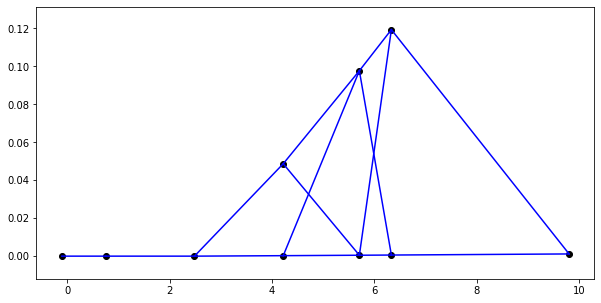

In [105]:
data = pd.read_csv(event_file)
data.rename(columns=lambda x: x.strip(), inplace=True)

data = data[data['hitType'] == 0]
removeNoise = True
if removeNoise:
  data = data[data['trackID'].isin([0, 1, 2])]
event = data[data['nEvent'] == 14]
print(event)
d = gen2D_event_data(event)
print(d.x,
d.edge_index,
d.y,
d.nevent)
plot_toy_graph(d, 0.)

In [106]:
datasetX = LoadHitFile(event_file, True)

In [15]:
datasetY = LoadHitFile(event_file, True)

In [107]:
dataset = datasetX
from sklearn.model_selection import train_test_split
train_dataset, test_dataset = train_test_split(dataset, test_size=0.2, random_state=42)
train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=True)

/usr/local/lib/python3.8/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [108]:
dataset[0].edge_index
dataset[0].x
dataset[0].nevent

1

In [109]:
def plot_toy_graph(event, ylim=0.):
    plt.figure(figsize=(10,5))
    x, y = event.x[:,0].numpy(), event.x[:,1].numpy()
    e = event.edge_index.numpy()
    plt.plot([x[e[0,:]], x[e[1,:]]], [y[e[0,:]], y[e[1,:]]], c='b')
    plt.scatter(x, y, c='k')
    if (ylim!=0):
       plt.ylim(-ylim,ylim)
    else:
       diff = 0.1*(max(y)-min(y))
       plt.ylim(min(y)-diff, max(y)+diff)   

tensor([[-1.0500e-01, -2.8643e-10],
        [ 7.5500e-01, -2.7315e-06],
        [ 2.4850e+00, -5.6176e-07],
        [ 4.2185e+00,  1.4678e-02],
        [ 4.2185e+00, -9.4414e-04],
        [ 5.7050e+00,  2.8580e-02],
        [ 5.7050e+00, -1.8687e-03],
        [ 6.3300e+00,  3.4526e-02],
        [ 6.3300e+00, -2.2560e-03],
        [ 9.8000e+00,  6.7036e-02],
        [ 9.8000e+00, -4.3724e-03]])
Fake / True =  1.0
Training dataset (events):  800
Test dataset (events):  200


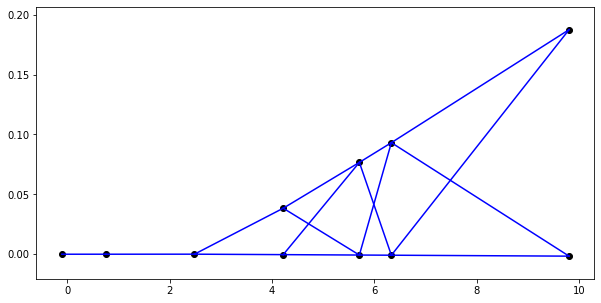

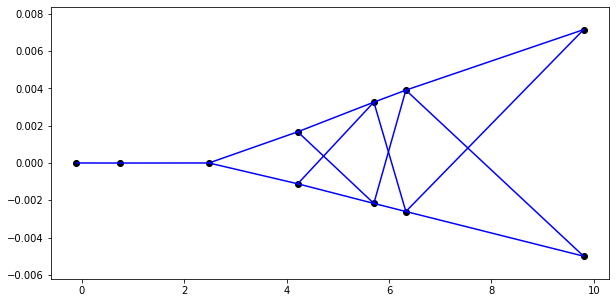

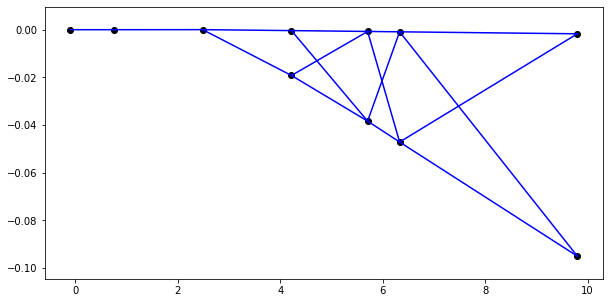

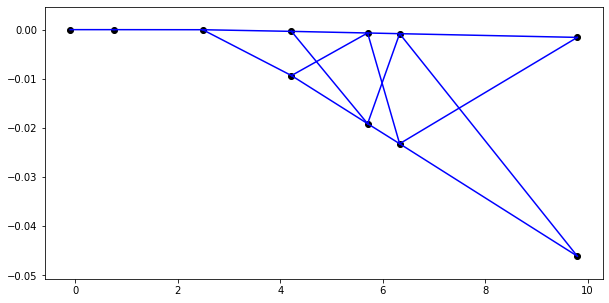

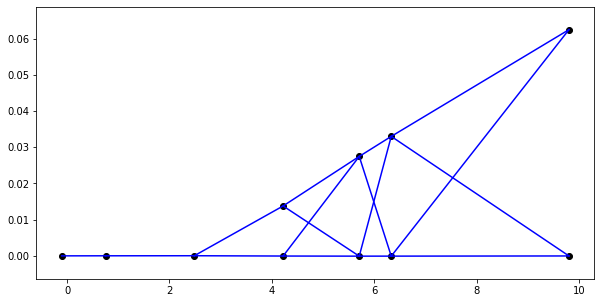

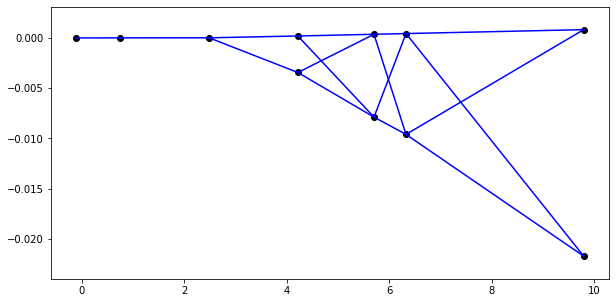

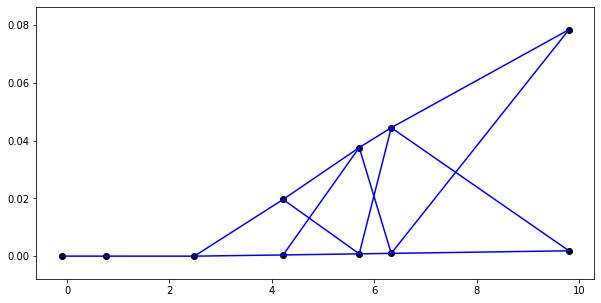

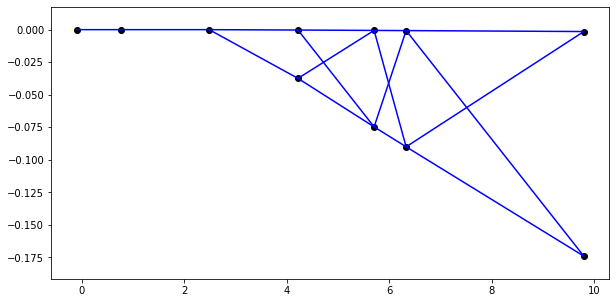

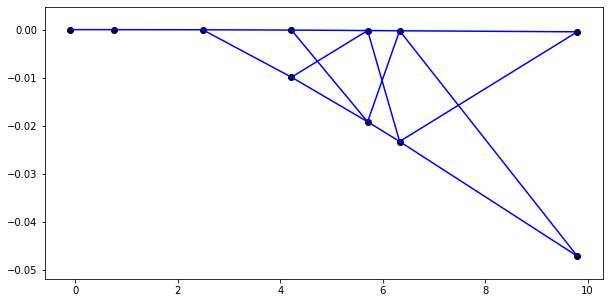

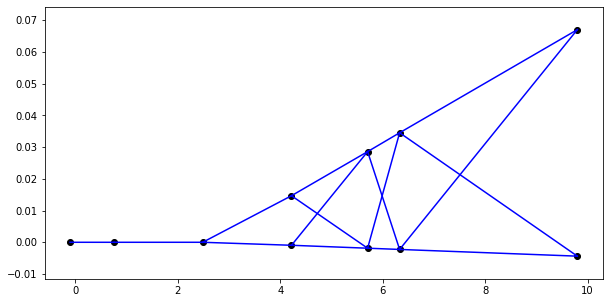

In [110]:
# Display few events
for k in range(0, 10):
   plot_toy_graph(train_loader.dataset[k], 0.)

print(train_loader.dataset[k].x)

print("Fake / True = ", (len(train_dataset[0].y) - train_dataset[0].y.sum().item()) / train_dataset[0].y.sum().item())

print("Training dataset (events): ",len(train_dataset))
print("Test dataset (events): ",len(test_dataset))

In [111]:
train_dataset[0]

Data(x=[11, 2], edge_index=[2, 16], y=[16], nevent=30)

tensor([[-1.0500e-01,  2.4170e-09],
        [ 7.5500e-01,  8.9814e-06],
        [ 2.4850e+00,  4.1770e-05],
        [ 4.2185e+00, -1.9652e-02],
        [ 4.2185e+00, -4.5710e-04],
        [ 5.7050e+00, -3.8482e-02],
        [ 5.7050e+00, -9.0835e-04],
        [ 6.3300e+00, -4.6363e-02],
        [ 6.3300e+00, -1.0991e-03],
        [ 9.8000e+00, -8.9815e-02],
        [ 9.8000e+00, -2.1199e-03]]) tensor([[ 6,  5,  4,  5,  7,  3,  8,  2,  7,  8,  2,  0,  3,  1,  4,  6],
        [ 7,  8,  5,  7, 10,  5,  9,  4,  9, 10,  3,  1,  6,  2,  6,  8]]) tensor([0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1]) 2


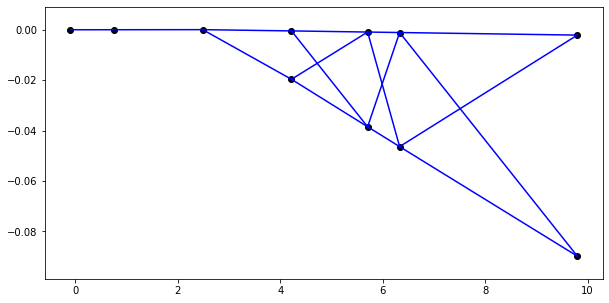

In [114]:
k=1
print(dataset[k].x,
dataset[k].edge_index,
dataset[k].y,
dataset[k].nevent)
plot_toy_graph(dataset[k], 0.)

In [112]:
for k in range(50):
  print(f"n {dataset[k].nevent}, {len(dataset[k].x)}, {len(dataset[k].y)}")

n 1, 11, 16
n 2, 11, 16
n 3, 11, 16
n 4, 11, 16
n 5, 11, 16
n 6, 11, 16
n 7, 11, 16
n 8, 11, 16
n 9, 11, 16
n 10, 11, 16
n 11, 11, 16
n 12, 11, 16
n 13, 11, 16
n 14, 10, 14
n 15, 11, 16
n 16, 11, 16
n 17, 11, 16
n 18, 11, 16
n 19, 11, 16
n 20, 11, 16
n 21, 11, 16
n 22, 11, 16
n 23, 11, 16
n 24, 11, 16
n 25, 11, 16
n 26, 11, 16
n 27, 11, 16
n 28, 11, 16
n 29, 11, 16
n 30, 11, 16
n 31, 11, 16
n 32, 11, 16
n 33, 11, 16
n 34, 11, 16
n 35, 11, 16
n 36, 11, 16
n 37, 11, 16
n 38, 11, 16
n 39, 11, 16
n 40, 11, 16
n 41, 11, 16
n 42, 11, 16
n 43, 11, 16
n 44, 11, 16
n 45, 11, 16
n 46, 11, 16
n 47, 11, 16
n 48, 11, 16
n 49, 11, 16
n 50, 11, 16


In [115]:
weight = ((len(train_dataset[0].y) - train_dataset[0].y.sum().item()) / train_dataset[0].y.sum().item())
print("True / Fake = ", 1/weight)
print("Fake / True = ", weight)

True / Fake =  1.0
Fake / True =  1.0


In [116]:
t_loss_v = []
t_acc_v = []
v_loss_v = []
v_acc_v = []
ep = 0
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
weight = 1

#device = torch.device('cpu')

m_configs = {'normalize_factor': 2000 ,"input_dim": 2, "hidden_node_dim": 64, "hidden_edge_dim": 128, "in_layers": 2, "node_layers": 2, "edge_layers": 2, "n_graph_iters": 10, "layer_norm": True}
model = MPNN_Network(**m_configs).to(device)

#m_configs = {"input_dim": 2, "hidden_node_dim": 64, "hidden_edge_dim": 64, "in_layers": 2, "node_layers": 4, "edge_layers": 4, "n_graph_iters": 1, "layer_norm": True}
#model = MPNN_Network(**m_configs).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-3, amsgrad=True)

for epoch in range(100):
    ep += 1  
    model.train()
    acc_t, total_loss = train(model, train_loader, optimizer)
    t_loss_v.append(total_loss)
    t_acc_v.append(acc_t)

    model.eval()
    acc, total_loss = evaluate(model, test_loader)
    v_loss_v.append(total_loss)
    v_acc_v.append(acc)
    if ep % 10 == 1 or True :
      print('Epoch: {}, Accuracy: {:.4f}'.format(ep, acc,acc_t))


Epoch: 1, Accuracy: 0.7589
Epoch: 2, Accuracy: 0.7792
Epoch: 3, Accuracy: 0.8164
Epoch: 4, Accuracy: 0.8918
Epoch: 5, Accuracy: 0.9193
Epoch: 6, Accuracy: 0.9459
Epoch: 7, Accuracy: 0.9593
Epoch: 8, Accuracy: 0.9765
Epoch: 9, Accuracy: 0.9803
Epoch: 10, Accuracy: 0.9841
Epoch: 11, Accuracy: 0.9850
Epoch: 12, Accuracy: 0.9875
Epoch: 13, Accuracy: 0.9881
Epoch: 14, Accuracy: 0.9891
Epoch: 15, Accuracy: 0.9912
Epoch: 16, Accuracy: 0.9922
Epoch: 17, Accuracy: 0.9919
Epoch: 18, Accuracy: 0.9928
Epoch: 19, Accuracy: 0.9934
Epoch: 20, Accuracy: 0.9934
Epoch: 21, Accuracy: 0.9931
Epoch: 22, Accuracy: 0.9931
Epoch: 23, Accuracy: 0.9937
Epoch: 24, Accuracy: 0.9928
Epoch: 25, Accuracy: 0.9934
Epoch: 26, Accuracy: 0.9931
Epoch: 27, Accuracy: 0.9934
Epoch: 28, Accuracy: 0.9934
Epoch: 29, Accuracy: 0.9934
Epoch: 30, Accuracy: 0.9928
Epoch: 31, Accuracy: 0.9934
Epoch: 32, Accuracy: 0.9922
Epoch: 33, Accuracy: 0.9931
Epoch: 34, Accuracy: 0.9937
Epoch: 35, Accuracy: 0.9925
Epoch: 36, Accuracy: 0.9925
E

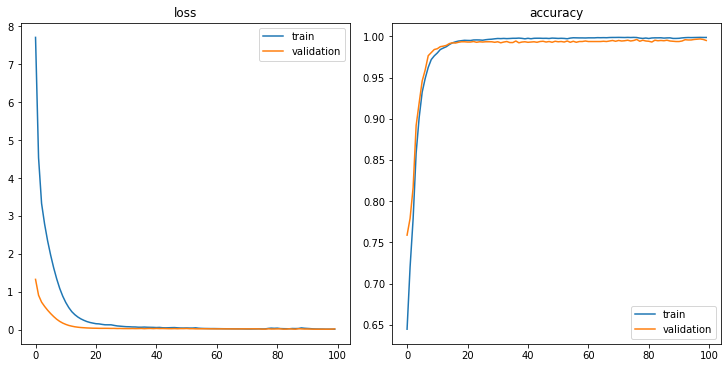

In [117]:
fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(10, 5))
axs[0].set_title("loss")
axs[0].set_yscale("linear")
axs[0].plot(np.arange(len(t_loss_v)), t_loss_v, label='train')
axs[0].plot(np.arange(len(v_loss_v)), v_loss_v, label='validation')
axs[0].legend()

axs[1].set_title("accuracy")
axs[1].plot(np.arange(len(t_acc_v)), t_acc_v, label='train')
axs[1].plot(np.arange(len(v_acc_v)), v_acc_v, label='validation')
axs[1].legend()
axs[1].set_yscale("linear")

In [118]:
def plot_toy_classified(event, preds, cut=0.5):
    
    #print("New event")
        
    #print(event)
    #print(event.x)
    #print(event.pid)
    #print(event.y)
    #gprint(preds)

    plt.figure(figsize=(10,5))
    x, y = event.x[:,0].numpy(), event.x[:,1].numpy()
    edges = event.edge_index.numpy()
    labels = event.y
    plt.scatter(x, y, c='k')
    plt.title(event.nevent)
    preds = preds.detach().numpy()
    

    for j in range(len(labels)):
        
        #print(str('%01.2f' % preds[j])+" "+str(labels[j].item())+" "+str(x[edges[0,j]]*feature_scale)+","+str(y[edges[0,j]]*feature_scale)+" "+str(x[edges[1,j]]*feature_scale)+","+str(y[edges[1,j]]*feature_scale))
        s = str('%01.2f' % preds[j])+" "+str(labels[j].item())
        plt.text((x[edges[0,j]]+x[edges[1,j]])/2., (y[edges[0,j]]+y[edges[1,j]])/2.+np.random.random(1)*0.00, s, fontsize=12)

        # False negatives
        if preds[j] < cut and labels[j].item() > cut:
            plt.plot([x[edges[0,j]], x[edges[1,j]]],
                     [y[edges[0,j]], y[edges[1,j]]],
                     '--', c='b')

        # False positives
        if preds[j] > cut and labels[j].item() < cut:
            plt.plot([x[edges[0,j]], x[edges[1,j]]],
                     [y[edges[0,j]], y[edges[1,j]]],
                     '-', c='r', alpha=preds[j])

        # True positives
        if preds[j] > cut and labels[j].item() > cut:
            plt.plot([x[edges[0,j]], x[edges[1,j]]],
                     [y[edges[0,j]], y[edges[1,j]]],
                     '-', c='k', alpha=preds[j])
                
        # True negatives
        if preds[j] < cut and labels[j].item() < cut:
            plt.plot([x[edges[0,j]], x[edges[1,j]]],
                     [y[edges[0,j]], y[edges[1,j]]],
                     '-', c='k', alpha=preds[j])

In [119]:
def full_acc(test_loader):
  corr = 0
  for k in range(len(test_loader.dataset)):
    data = test_loader.dataset[k].to(device)
    preds = torch.sigmoid(model(data)).to('cpu')
    cut = 0.6
    corr += int(np.array_equal(preds.detach().numpy() > cut,data.to('cpu').y.detach().numpy()))
  return(corr/len(test_loader.dataset))

In [120]:
full_acc(test_loader)

0.975

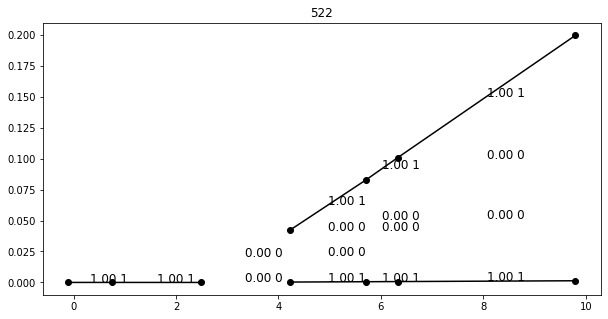

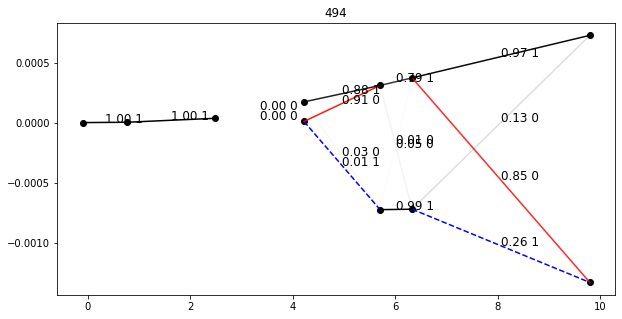

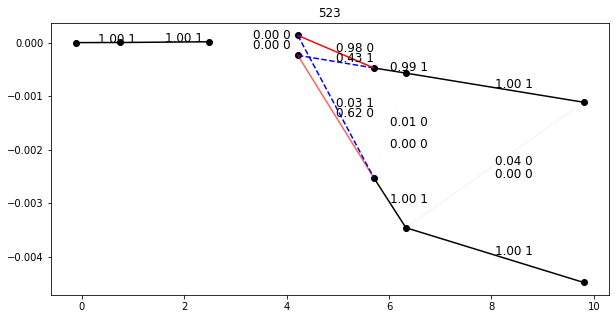

In [121]:
for k in range(100):
   data = test_loader.dataset[k].to(device)
   preds = torch.sigmoid(model(data)).to('cpu')
   cut = 0.6
   if not np.array_equal(preds.detach().numpy() > cut,data.to('cpu').y.detach().numpy()) or k == 0:
     plot_toy_classified(data.to('cpu'), preds, cut = cut)